In [265]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate

In [268]:
#  Fetch stock data from Yahoo Finance
ticker = "TSLA"
start_date = "2018-01-01"
end_date = "2025-03-14"

# Download stock data
df = yf.download(ticker, start=start_date, end=end_date)

# Reset index and rename columns
df.columns = df.columns.droplevel(1)

# Display first rows
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000
2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500
2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500
2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000
2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1809 entries, 2018-01-02 to 2025-03-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1809 non-null   float64
 1   High    1809 non-null   float64
 2   Low     1809 non-null   float64
 3   Open    1809 non-null   float64
 4   Volume  1809 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 84.8 KB


In [270]:
df.describe()

Price,Close,High,Low,Open,Volume
count,1809.000000,1809.000000,1809.000000,1809.000000,1.809000e+03
mean,163.255002,167.002505,159.399270,163.362018,1.267066e+08
std,115.653568,118.412205,112.918704,115.863279,7.893891e+07
min,11.931333,12.445333,11.799333,12.073333,2.940180e+07
25%,23.328667,23.713333,23.011999,23.375999,7.798950e+07
50%,187.039993,190.513336,182.110001,186.000000,1.042026e+08
75%,246.720001,252.419998,242.009995,247.449997,1.463600e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


Text(0, 0.5, 'Close Price')

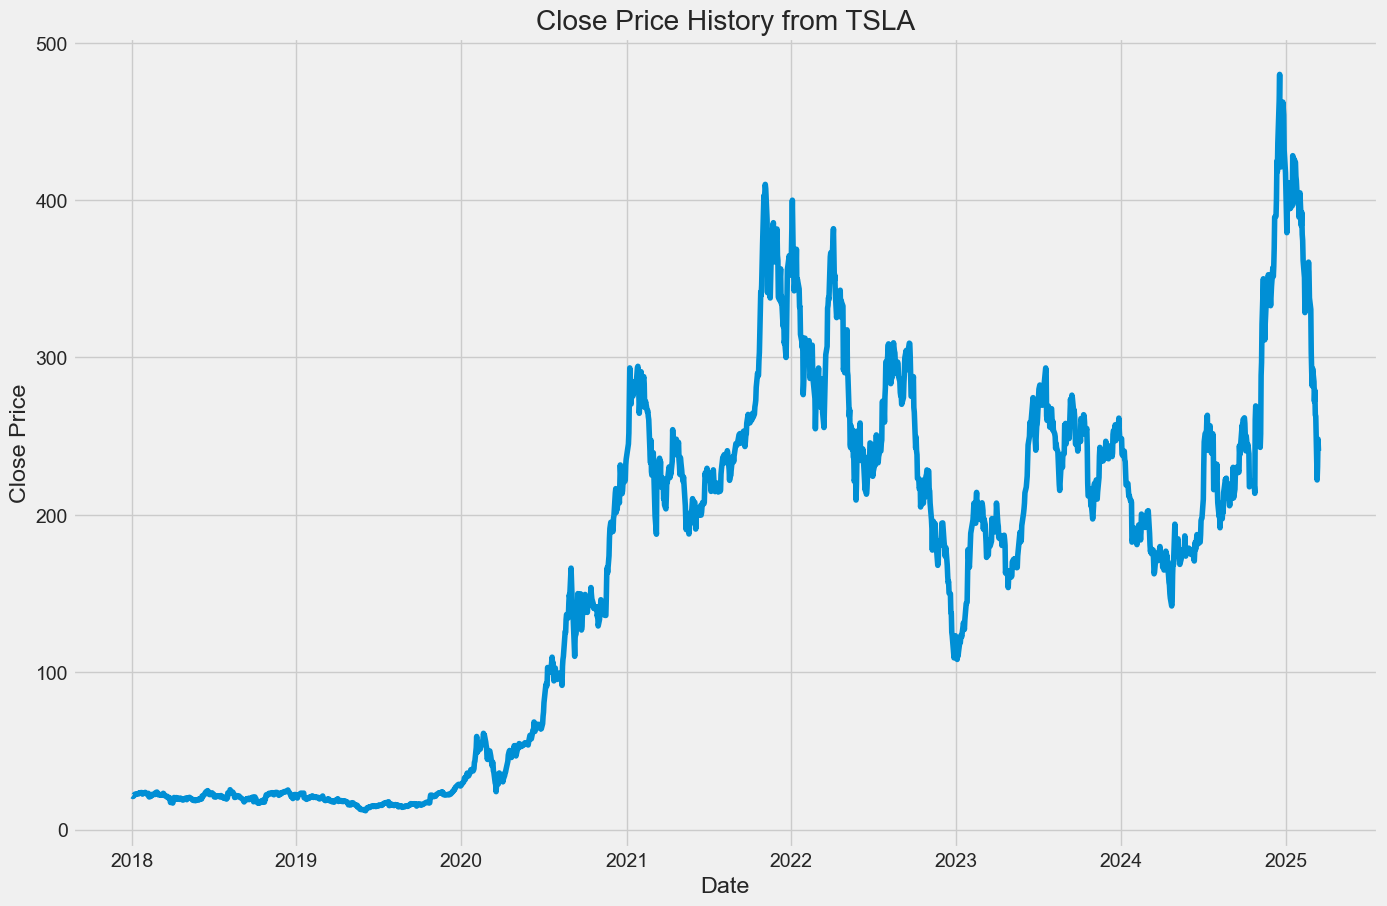

In [271]:
plt.figure(figsize=(15, 10))
plt.plot(df['Close'])
plt.title('Close Price History from ' + ticker)
plt.xlabel('Date')
plt.ylabel('Close Price')

Text(0, 0.5, 'MA Price')

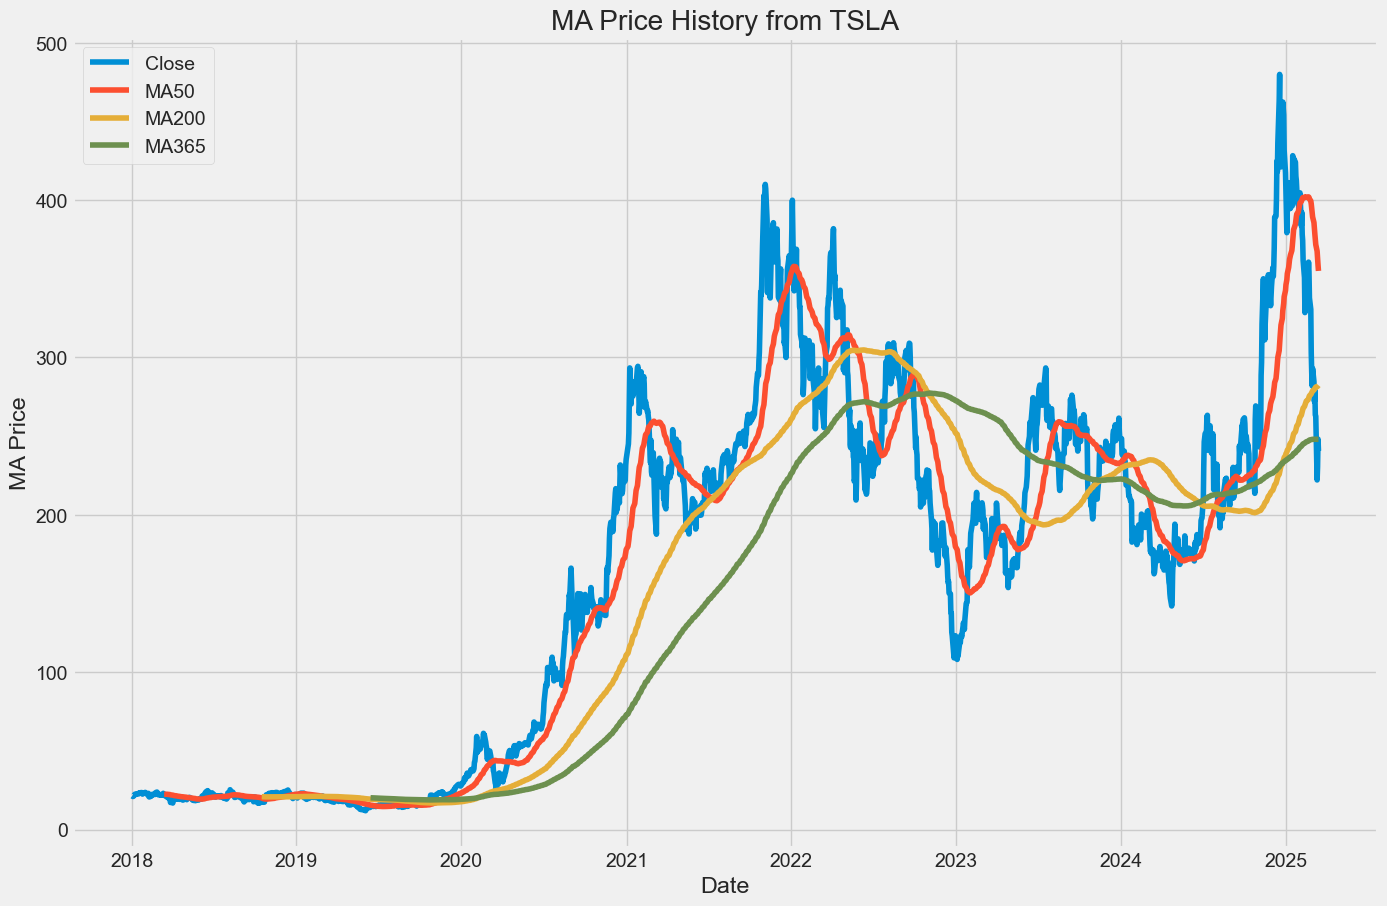

In [272]:
df['MA50']=df['Close'].rolling(50).mean()
df['MA200']=df['Close'].rolling(200).mean()
df['MA365']=df['Close'].rolling(365).mean()

plt.figure(figsize=(15, 10))
plt.plot(df['Close'])
plt.plot(df['MA50'])
plt.plot(df['MA200'])
plt.plot(df['MA365'])

plt.legend(['Close', 'MA50', 'MA200', 'MA365'])
plt.title('MA Price History from ' + ticker)
plt.xlabel('Date')
plt.ylabel('MA Price')

In [273]:
# Normalize data
df=df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Create sequences
seq_length = 30
X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i + seq_length])
    y.append(scaled_data[i + seq_length])

X, y = np.array(X), np.array(y)

In [274]:
# Train-test split (80-20)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [275]:
# Function to build and train model
def build_and_train_model(model_type, input_shape, X_train, y_train, epochs=20, batch_size=64):
    model = Sequential()

    if model_type == "LSTM":
        model.add(Input(shape=input_shape))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(LSTM(64))

    elif model_type == "GRU":
        model.add(Input(shape=input_shape))
        model.add(GRU(128, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(GRU(64))

    elif model_type == "LSTM+GRU":
        model.add(Input(shape=input_shape))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(GRU(64))

    model.add(Dense(64))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, history

# Train models and collect histories
lstm_model, lstm_history = build_and_train_model("LSTM", (seq_length, 1), X_train, y_train)
gru_model, gru_history = build_and_train_model("GRU", (seq_length, 1), X_train, y_train)
lstm_gru_model, lstm_gru_history = build_and_train_model("LSTM+GRU", (seq_length, 1), X_train, y_train)

# Make predictions
lstm_preds = lstm_model.predict(X_test)
gru_preds = gru_model.predict(X_test)
lstm_gru_preds = lstm_gru_model.predict(X_test)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0408
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.4580e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.7738e-04
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.7085e-04
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.6691e-04
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.4877e-04
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.1115e-04
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.1340e-04
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.0220e-04
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 

In [276]:
# Inverse transform predictions
lstm_preds = scaler.inverse_transform(lstm_preds)
gru_preds = scaler.inverse_transform(gru_preds)
lstm_gru_preds = scaler.inverse_transform(lstm_gru_preds)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Function to calculate RMSE, MSE, R²
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mse, r2

metrics = {
    "LSTM": calculate_metrics(y_test_actual, lstm_preds),
    "GRU": calculate_metrics(y_test_actual, gru_preds),
    "LSTM+GRU": calculate_metrics(y_test_actual, lstm_gru_preds)
}

# Select the best model (lowest RMSE)
best_model_name = min(metrics, key=lambda k: metrics[k][0])
best_model = {"LSTM": lstm_model, "GRU": gru_model, "LSTM+GRU": lstm_gru_model}[best_model_name]

# Tabulate results (3 decimal places)
table = [["Model", "RMSE", "MSE", "R²"]]
for model, (rmse, mse, r2) in metrics.items():
    table.append([model, f"{rmse:.3f}", f"{mse:.3f}", f"{r2:.3f}"])

print("\n📊 Model Performance Comparison:")
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))


📊 Model Performance Comparison:
╒══════════╤════════╤═════════╤═══════╕
│ Model    │   RMSE │     MSE │    R² │
╞══════════╪════════╪═════════╪═══════╡
│ LSTM     │ 16.968 │ 287.909 │ 0.95  │
├──────────┼────────┼─────────┼───────┤
│ GRU      │ 12.681 │ 160.805 │ 0.972 │
├──────────┼────────┼─────────┼───────┤
│ LSTM+GRU │ 14.764 │ 217.987 │ 0.962 │
╘══════════╧════════╧═════════╧═══════╛


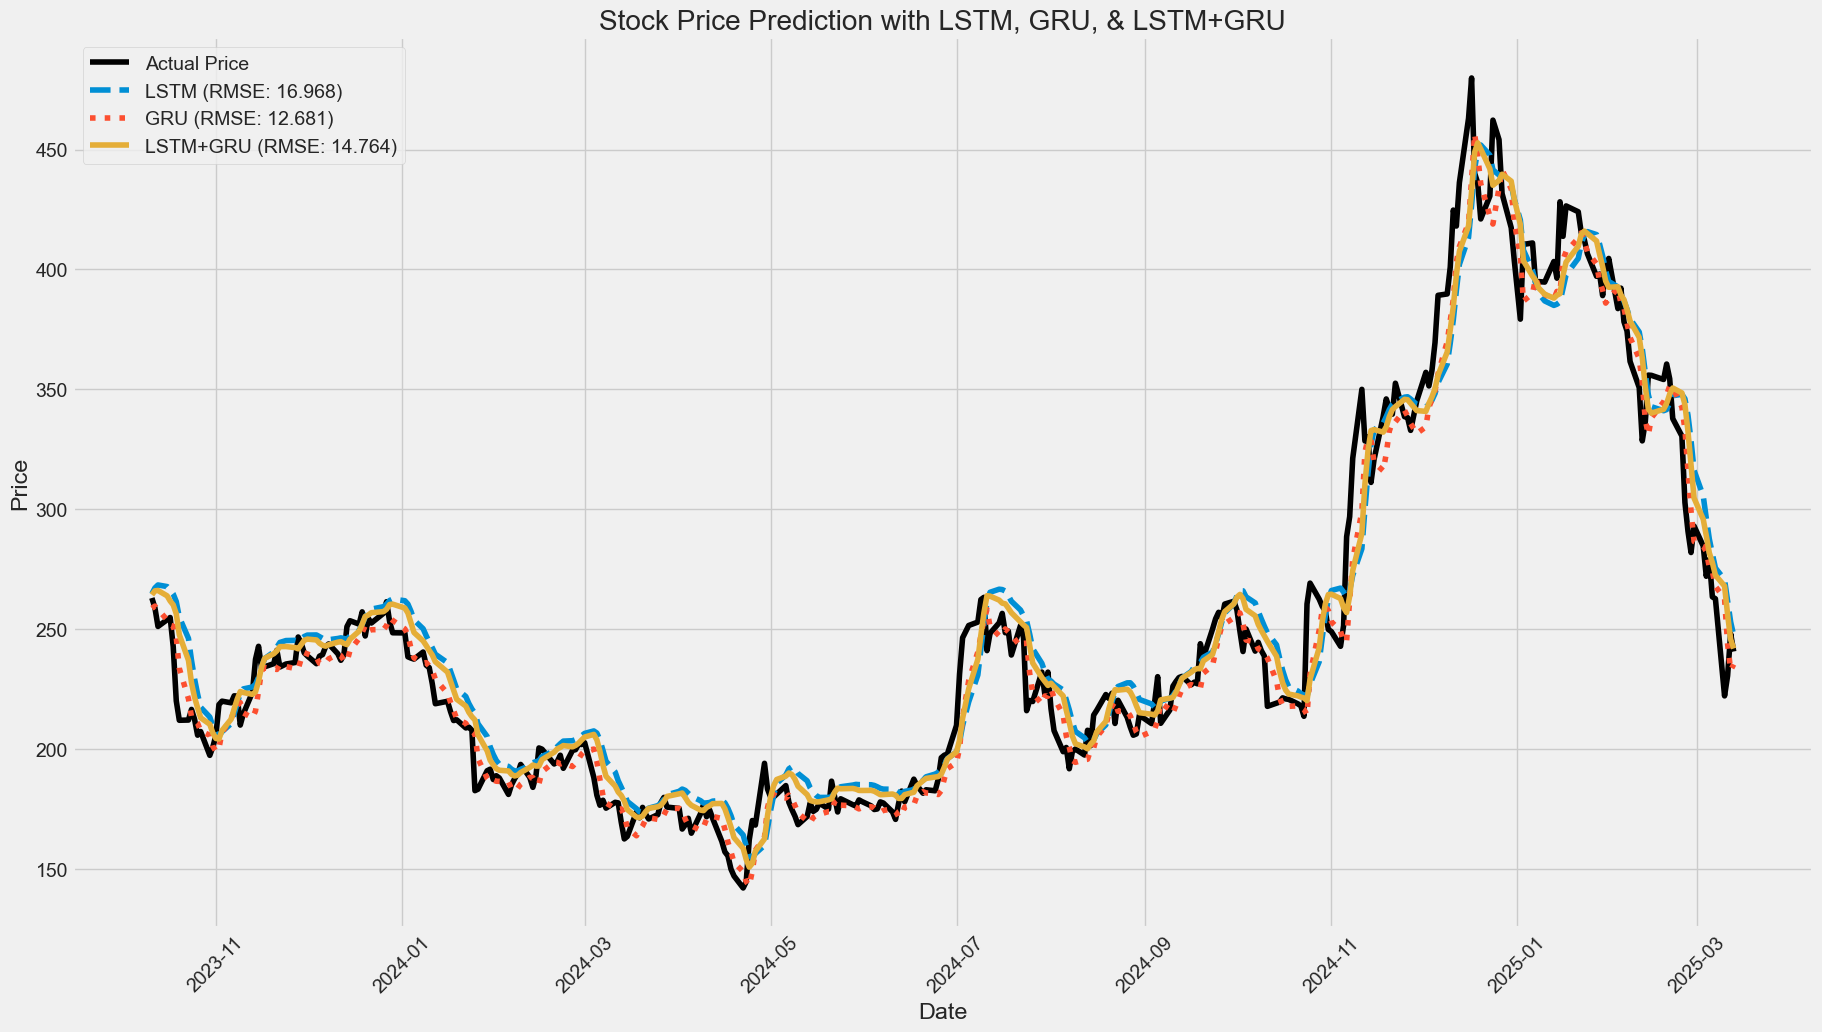

In [277]:
# Plot predictions vs actual values
plt.figure(figsize=(20, 11))
plt.plot(df.index[seq_length:][train_size:], y_test_actual, label='Actual Price', color='black')
plt.plot(df.index[seq_length:][train_size:], lstm_preds, label=f'LSTM (RMSE: {metrics["LSTM"][0]:.3f})',
         linestyle='dashed')
plt.plot(df.index[seq_length:][train_size:], gru_preds, label=f'GRU (RMSE: {metrics["GRU"][0]:.3f})',
         linestyle='dotted')
plt.plot(df.index[seq_length:][train_size:], lstm_gru_preds, label=f'LSTM+GRU (RMSE: {metrics["LSTM+GRU"][0]:.3f})',
         linestyle='solid')
plt.legend()
plt.title('Stock Price Prediction with LSTM, GRU, & LSTM+GRU')
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

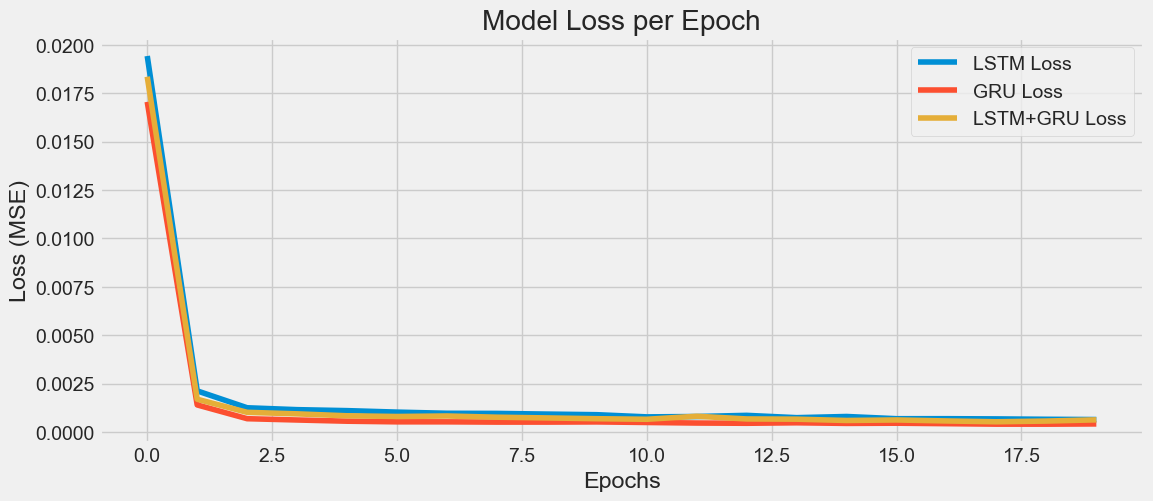

In [279]:
# Plot model loss (epochs)
plt.figure(figsize=(12, 5))
plt.plot(lstm_history.history['loss'], label="LSTM Loss")
plt.plot(gru_history.history['loss'], label="GRU Loss")
plt.plot(lstm_gru_history.history['loss'], label="LSTM+GRU Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Loss per Epoch")
plt.show()